In [14]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Load the precomputed Model for Hybrid Approach

In [33]:
f = open('../models/item_model', 'rb')
item_model = pickle.load(f)
f.close()

In [61]:
f = open('../models/lshbestmodel', 'rb')
lsh = pickle.load(f)
f.close()

In [7]:
data = pd.read_csv('../clean-data/Combine.csv')

rows = data.user_id.unique()
cols = data['isbn'].unique()
print(data.user_id.nunique(), data.isbn.nunique())
data = data[['user_id', 'isbn', 'book_rating']]

idict  = dict(zip(cols, range(len(cols))))
udict = dict(zip(rows, range(len(rows))))

data.user_id = [
    udict[i] for i in data.user_id
]
data['isbn'] = [
    idict[i] for i in data['isbn']
]

nmat = data.as_matrix()
nmat = nmat.astype(int)
print(nmat.shape)

naive = np.zeros((len(rows),len(cols)))
for row in nmat:
    naive[row[0], row[1]] = row[2]

print(naive.T.shape)

12053 4959
(470749, 3)
(4959, 12053)


In [12]:
amean = np.mean(naive[naive!=0])
umean = sum(naive.T) / sum((naive!=0).T)
imean = sum(naive) / sum((naive!=0))

umean = np.where(np.isnan(umean), amean, umean)
imean = np.where(np.isnan(imean), amean, imean)

In [17]:
def rmse(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return np.sqrt(mean_squared_error(ypred, ytrue))

def mae(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return mean_absolute_error(ypred, ytrue)

In [18]:
def predict(user, item, mat, model, amean, umean, imean,  k=20):
    nzero = naive[user].nonzero()[0]
    if len(nzero) == 0:
        return amean
    diction = dict(model[item])
    elems = set(nzero).intersection(diction.keys())
    baseline = imean + umean[user] - amean

    new_dict = sorted({k: diction[k] for k in elems if k in diction}.items(),  key=lambda x: x[1], reverse = True)[:k]
    if(not len(new_dict)):
        return amean
    num=0
    denum =0 
    for i in new_dict:
        num+= (naive[user,i[0]]-baseline[i[0]])*i[1]
        denum+=i[1]
    prediction = (num/denum + baseline[item])
    
    if np.isnan(prediction):
        prediction = imean[item] + umean[user] - amean
    if prediction > 5:
        prediction = 5
    if prediction < 1:
        prediction = 1
    return prediction

In [34]:
def predict2(user, item, mat, item_similarity, amean, umean, imean,  k=20):
    nzero = mat[user].nonzero()[0]
    if len(nzero) == 0:
        return amean
    baseline = imean + umean[user] - amean
    choice = nzero[item_similarity[item, nzero].argsort()[::-1][1:k+1]]

    prediction = ((mat[user, choice] - baseline[choice]).dot(item_similarity[item, choice])/ sum(item_similarity[item, choice])) + baseline[item]
        
    if np.isnan(prediction):
        prediction = imean[item] + umean[user] - amean
    if prediction > 5:
        prediction = 5
    if prediction < 1:
        prediction = 1
    return prediction

# Weighted Average Hybrid Model

In [38]:
def get_results1(X, rows, cols, folds, k, item_sim1, item_sim2, weights, amean, umean, imean):
    kf =  KFold(n_splits=folds, shuffle = True, random_state=42)
    count = 1
    rmse_list = []
    mae_list = []
    trmse_list = []
    tmae_list = []
    for train_index, test_index in kf.split(X):
        print("----------   Fold ", count, "---------------")
        train_data, test_data = X[train_index], X[test_index]
        
        full_mat = np.zeros((rows, cols))
        
        for row in train_data:
            full_mat[row[0], row[1]] = row[2]
        
        
        preds = []
        real = []
        
        for row in test_data:
            user_id, isbn, rating = row[0], row[1], row[2]
            pred1 = predict(user_id, isbn, full_mat, item_sim1, amean, umean, imean, k)
            pred2 = predict2(user_id, isbn, full_mat, item_sim2, amean, umean, imean,  k)
            preds.append(weights[0] * pred1 + weights[1] * pred2)
            real.append(rating)
            
        err1 = rmse(np.array(preds), np.array(real))
        err2 = mae(np.array(preds), np.array(real))
        rmse_list.append(err1)
        mae_list.append(err2)
        
       
        
        print('Test Errors')
        print('RMSE : %.4f' % err1)
        print('MAE : %.4f' % err2)
        count+=1
        
    
    print("-------------------------------------")
#     print("Training Avg Error:")
#     print("AVG RMSE :", str(np.mean(trmse_list)))
#     print("AVG MAE :", str(np.mean(tmae_list)))
    print()
    print("Testing Avg Error:")
    print("AVG RMSE :", str(np.mean(rmse_list)))
    print("AVG MAE :", str(np.mean(mae_list)))
    print(" ")
        
    return np.mean(mae_list), np.mean(rmse_list)


## Tuning the model weights for lower errors

In [70]:
get_results1(nmat, len(rows), len(cols), 5, 15, lsh, item_model, [0.7, 0.3], amean, umean, imean)

----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Test Errors
RMSE : 0.8035
MAE : 0.5857
----------   Fold  2 ---------------
Test Errors
RMSE : 0.8032
MAE : 0.5839
----------   Fold  3 ---------------
Test Errors
RMSE : 0.7975
MAE : 0.5822
----------   Fold  4 ---------------
Test Errors
RMSE : 0.7963
MAE : 0.5817
----------   Fold  5 ---------------
Test Errors
RMSE : 0.7992
MAE : 0.5839
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.799918947078
AVG MAE : 0.583491996023
 


(0.58349199602324886, 0.79991894707783184)

In [63]:
get_results1(nmat, len(rows), len(cols), 5, 15, lsh, item_model, [0.8, 0.2], amean, umean, imean)

----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Test Errors
RMSE : 0.8098
MAE : 0.5874
----------   Fold  2 ---------------
Test Errors
RMSE : 0.8096
MAE : 0.5856
----------   Fold  3 ---------------
Test Errors
RMSE : 0.8036
MAE : 0.5836
----------   Fold  4 ---------------
Test Errors
RMSE : 0.8021
MAE : 0.5829
----------   Fold  5 ---------------
Test Errors
RMSE : 0.8053
MAE : 0.5856
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.806073740938
AVG MAE : 0.585022709427
 


(0.58502270942728418, 0.8060737409378268)

In [68]:
get_results1(nmat, len(rows), len(cols), 5, 15, lsh, item_model, [0.9, 0.1], amean, umean, imean)

----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Test Errors
RMSE : 0.8178
MAE : 0.5898
----------   Fold  2 ---------------
Test Errors
RMSE : 0.8178
MAE : 0.5880
----------   Fold  3 ---------------
Test Errors
RMSE : 0.8114
MAE : 0.5858
----------   Fold  4 ---------------
Test Errors
RMSE : 0.8096
MAE : 0.5848
----------   Fold  5 ---------------
Test Errors
RMSE : 0.8131
MAE : 0.5878
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.81394307864
AVG MAE : 0.587237204506
 


(0.58723720450551642, 0.81394307864027571)

In [69]:
get_results1(nmat, len(rows), len(cols), 5, 15, lsh, item_model, [0.6, 0.4], amean, umean, imean)

----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Test Errors
RMSE : 0.7990
MAE : 0.5848
----------   Fold  2 ---------------
Test Errors
RMSE : 0.7985
MAE : 0.5830
----------   Fold  3 ---------------
Test Errors
RMSE : 0.7931
MAE : 0.5814
----------   Fold  4 ---------------
Test Errors
RMSE : 0.7922
MAE : 0.5813
----------   Fold  5 ---------------
Test Errors
RMSE : 0.7948
MAE : 0.5830
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.795518491884
AVG MAE : 0.582695248907
 


(0.58269524890672009, 0.79551849188400536)

In [66]:
get_results1(nmat, len(rows), len(cols), 5, 15, lsh, item_model, [0.5, 0.5], amean, umean, imean)

----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Test Errors
RMSE : 0.7962
MAE : 0.5846
----------   Fold  2 ---------------
Test Errors
RMSE : 0.7956
MAE : 0.5828
----------   Fold  3 ---------------
Test Errors
RMSE : 0.7905
MAE : 0.5815
----------   Fold  4 ---------------
Test Errors
RMSE : 0.7899
MAE : 0.5816
----------   Fold  5 ---------------
Test Errors
RMSE : 0.7923
MAE : 0.5829
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.792901584014
AVG MAE : 0.58266482577
 


(0.58266482577013645, 0.79290158401378918)

## Best K Selection for Hybrid Model with LSH weight 0.7 and Content Based Weight 0.3

In [72]:
each_sims = []
each_sims_rmse = []
for k in [5, 10, 15, 20, 25]:
    print("Nearest Neighbors: ",k)
    ans1, ans2  = get_results1(nmat, len(rows), len(cols), 5, k, lsh, item_model, [0.7, 0.3], amean, umean, imean)
    each_sims.append(ans1)
    each_sims_rmse.append(ans2)

print()
print("Best K Value for")
print()
print("Min MAE")
print(np.min(each_sims), np.argmin(each_sims))
print("Min RMSE")
print(np.min(each_sims_rmse), np.argmin(each_sims_rmse))
print()

Nearest Neighbors:  5
----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Test Errors
RMSE : 0.8125
MAE : 0.5897
----------   Fold  2 ---------------
Test Errors
RMSE : 0.8128
MAE : 0.5879
----------   Fold  3 ---------------
Test Errors
RMSE : 0.8062
MAE : 0.5857
----------   Fold  4 ---------------
Test Errors
RMSE : 0.8057
MAE : 0.5855
----------   Fold  5 ---------------
Test Errors
RMSE : 0.8085
MAE : 0.5878
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.809146188876
AVG MAE : 0.587324777311
 
Nearest Neighbors:  10
----------   Fold  1 ---------------
Test Errors
RMSE : 0.8048
MAE : 0.5858
----------   Fold  2 ---------------
Test Errors
RMSE : 0.8045
MAE : 0.5840
----------   Fold  3 ---------------
Test Errors
RMSE : 0.7986
MAE : 0.5821
----------   Fold  4 ---------------
Test Errors
RMSE : 0.7973
MAE : 0.5817
----------   Fold  5 ---------------
Test Errors
RMSE : 0.8003
MAE : 0.5840
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.801096639609
AVG MAE : 0.583508451591
 
Nearest Neighbors:  15
---------

In [337]:
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


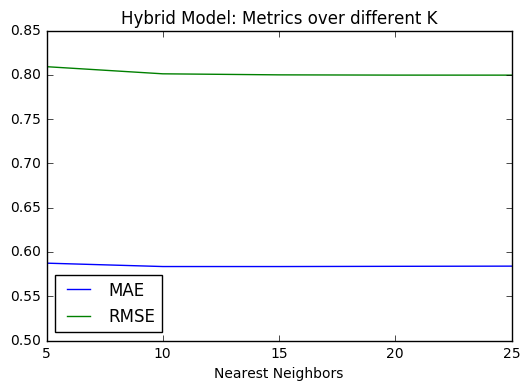

In [348]:
results_df1 = pd.DataFrame({'Nearest Neighbors': [5, 10, 15, 20, 25], 'MAE': each_sims, 'RMSE': each_sims_rmse })
plot1 = results_df1.plot(x='Nearest Neighbors', y=['MAE', 'RMSE'], ylim=(0.5,0.85), title = 'Hybrid Model: Metrics over different K')
fig = plot1.get_figure()
fig.savefig('MetricsHybrid.png')

In [46]:
flipped_dict = dict(zip(idict.values(), idict.keys()))

In [74]:
full_mat = np.zeros((len(rows),len(cols)))
for row in nmat:
    full_mat[row[0], row[1]] = row[2]

### Coverage for Hybrid Model

In [47]:
def coverage(full_mat, user_id, item_sim1, item_sim2, weights, k, mlist, flipped_dict,  cov = False):
    
    n = full_mat.shape[1]
    nzero = full_mat[user_id].nonzero()[0]
    
    preds = {}
    for row in range(n):
        pred1 = predict(user_id, row, full_mat, item_sim1, amean, umean, imean, k)
        pred2 = predict2(user_id, row, full_mat, item_sim2, amean, umean, imean,  k)

        preds[row] = weights[0] * pred1 + weights[1] * pred2
        
    if not cov:
        print("Books Read -----")
        for i in nzero:
            print(flipped_dict[i])
            del preds[i]
    
    
    res = sorted(preds.items(), key=lambda x: x[1], reverse = True)
    
    ret_tup = []
    ans = [flipped_dict[i[0]] for i in res[:mlist[-1]]]
    for i in mlist:
        ret_tup.append(ans[:i])
    
    return ret_tup

In [75]:
cov1 = []
cov2 = []
cov3 = []
cov4 = []
cov5 = []
mlist = [5,10,15,20,25]
for i in range(len(rows)):
    if(i%100 == 0):
        print(i)
    ans = coverage(full_mat, i, lsh, item_model, [0.7, 0.3], 15, mlist, flipped_dict, True)
    cov1.extend(ans[0])
    cov2.extend(ans[1])
    cov3.extend(ans[2])
    cov4.extend(ans[3])
    cov5.extend(ans[4])

0


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000


In [143]:
print("Coverage with recommending 5 books", len(set(cov1))/4959 *100 ,"%")

Coverage with recommending 5 books 27.808025811655572 %


In [144]:
print("Coverage with recommending 10 books", len(set(cov2))/4959 *100 ,"%")

Coverage with recommending 10 books 38.93930227868522 %


In [145]:
print("Coverage with recommending 15 books", len(set(cov3))/4959 *100 ,"%")

Coverage with recommending 15 books 46.541641459971764 %


In [146]:
print("Coverage with recommending 20 books", len(set(cov4))/4959 *100 ,"%")

Coverage with recommending 20 books 52.63157894736842 %


In [147]:
print("Coverage with recommending 25 books", len(set(cov5))/4959 *100 ,"%")

Coverage with recommending 25 books 57.8544061302682 %


### Get M Recommendation for a user using LSH Model

In [370]:
def getmrec(full_mat, user_id, item_similarity, k, m, flipped_dict,  cov = False):
    
    n = full_mat.shape[1]
    nzero = full_mat[user_id].nonzero()[0]
    
    preds = {}
    for row in range(n):
        preds[row] = predict(user_id, row, full_mat, item_similarity, amean, umean, imean, k)
    
    genre = []
    if not cov:
#         print("Books Read -----")
        for i in nzero:
#             print(flipped_dict[i])
            genre.extend(ansdict[i])
            del preds[i]
    
    newA = dict(sorted(preds.items(),key=operator.itemgetter(1), reverse = True)[:m])
    #res = sorted(preds.items(), key=lambda x: x[1], reverse = True)
    retgen = []
    for j in newA.keys():
        retgen.extend(ansdict[j])
        
    ans = [flipped_dict[i] for i in newA.keys()]
#     print("Books Read")
    df1 = pd.DataFrame.from_dict(dict(Counter(genre)),orient='index').sort_values(by=0,ascending = False)
#     print(df1)
#     print()
#     print("Book Recommended")
    df2 = pd.DataFrame.from_dict(dict(Counter(retgen)),orient='index').sort_values(by=0,ascending = False)
#     print(df2)
    
    df = pd.merge(left=df1, right=df2, left_index=True, right_index=True, how = 'outer').fillna(0)
    df.columns = ['Books Read', 'Books Recommended']
    df = df.sort_values(['Books Read','Books Recommended'], ascending = False)
    
#     print(df)
    
#     print(df1)

    return df , ans

In [371]:
df, ans = getmrec(full_mat, 130, lsh, 15, 10, flipped_dict,  cov = False)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [375]:
df

,Books Read,Books Recommended
Horror_Score,19.0,5.0
Biography_Score,13.0,2.0
Mystery_Score,6.0,7.0
Romance_Score,4.0,1.0
Fantasy_Score,2.0,1.0
Children_Score,2.0,0.0
History_Score,1.0,3.0
Autobiography_Score,1.0,0.0
Drama_Score,0.0,1.0


In [387]:
# print("\n\n==========[ RECOMMENDED BOOKS]==========\n")
# for book in ans:
#     print("  " + book)
# print("\n\n")

df2 = pd.DataFrame(ans,columns=['Recommended Books'])

df2

,Recommended Books
0,For Whom the Bell Tolls
1,Open: An Autobiography
2,Night
3,"Deeply Odd (Odd Thomas, #6)"
4,Unbroken
5,Eye of the Needle
6,Don Quixote
7,The Graveyard Book
8,To Kill a Mockingbird
9,"The Lion, the Witch and the Wardrobe (Chronicl..."


### Getting the right data structure; Not Important

In [148]:
data = pd.read_pickle('../created_datasets/ibsn_features_new_batch.pickle')

In [149]:
name = data.title

In [150]:
name = list(name)

In [151]:
for i in range(len(flipped_dict)):
    flipped_dict[i] = name[i]
    

In [158]:
feats.head()

,Unnamed: 0,Science_Score,Satire_Score,Drama_Score,Action_Score,Romance_Score,Mystery_Score,Horror_Score,Travel_Score,Children_Score,Religion_Score,History_Score,Biography_Score,Autobiography_Score,Fantasy_Score,isbn,title
0,0,0.038207,0.068504,0.069262,0.034280,0.067933,0.080699,0.093292,0.048437,0.067634,0.058378,0.065526,0.045191,0.044895,0.071272,0002007770,Water for Elephants
1,1,0.039468,0.075064,0.061319,0.055943,0.092886,0.093401,0.090650,0.063545,0.055523,0.064056,0.094257,0.073566,0.068922,0.071120,0002051850,For Whom the Bell Tolls
2,2,0.037345,0.061224,0.052370,0.034974,0.064670,0.076909,0.076948,0.040161,0.049419,0.057505,0.076696,0.031504,0.030831,0.060471,0002247399,"A Dance with Dragons (A Song of Ice and Fire, #5)"
3,3,0.040277,0.059965,0.056401,0.040376,0.068644,0.090155,0.089819,0.046808,0.054902,0.057387,0.068051,0.053922,0.046720,0.067391,0006476155,"Along Came a Spider (Alex Cross, #1)"
4,4,0.024843,0.050273,0.067219,0.023418,0.088785,0.081145,0.076581,0.041120,0.087698,0.046154,0.067406,0.054567,0.061165,0.064440,0006514006,The Other Boleyn Girl


In [333]:
def get_top_two_indices(x):
    
#     l = list(x.values)
    
#     return l.index(max(l))

    return pd.Series(x.sort_values(ascending = False).head(2).index.values)

In [334]:
ansdict = feats.loc[:,'Science_Score':'Fantasy_Score'].apply(get_top_two_indices,axis=1).T.to_dict(orient='list')